In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import adabound # https://github.com/Luolc/AdaBound
from torchsummary import summary

# TorchCAM
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp
from mpl_toolkits.axes_grid1 import ImageGrid

from torch.utils.tensorboard import SummaryWriter

# For notificaiton
import AppKit

# CNN - CIFAR-10 - Adam - TorchCAM - Pool

Files already downloaded and verified
Files already downloaded and verified


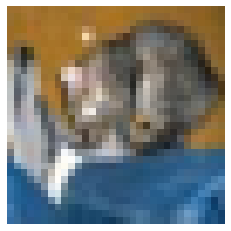

In [267]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 20
batch_size = 1
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/CIFAR10/v1.1.2 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer1  = SummaryWriter(log_directory)
#writer2 = SummaryWriter(log_directory)

# Loading dataset
# Since the dataset is in PIL (Python Imaging Library) form, tranform them into tensors of normalised range [-1, 1]
transform = transforms.Compose( # this transforms.compose combines multiple tranformations as one
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# The CIFAR10 tataset is avaliable in PyTorch
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=False, download=True, transform=transform)

# Splitting the training and testing datasets into smaller batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Checking a data sample 
example = iter(test_loader)
images, labels = example.next()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

def im_transpose(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

imshow(torchvision.utils.make_grid(images))

In [254]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)      # Input 3 (RGB), 6 (outputs), 5 (kernel size)
        self.pool  = nn.MaxPool2d(2, 2)      # Kernel size of 2 with stride of 2
        self.conv2 = nn.Conv2d(6, 16, 5)     # Input 6 (conv1's output), 16 (outputs), 5 (kernel size)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)    # Input 16 (conv1's output), 32 (outputs), 5 (kernel size) # Stop here
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)    # Input 32 (conv1's output), 64 (outputs), 3 (kernel size)
        # Classification layers
        x = self.dropout(x)
        self.fc1   = nn.Linear(64*5*5, 120)   # Fully connected linear layer. 16 is the output of conv2 and 5x5 is
#                                             the output dimention after conv1->pool->conv2->pool. 
#                                             The process can be observed in the coming cells.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        # Output is 10 as we have 10 classes in the CIFAR-10 dataset
        self.dropout = nn.Dropout(p=0.10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #x.register_hook(self.activations_hook)
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flattening x. # -1 makes pytorch infer the dimensionality, which in this case is the number of batches (4).
# It does this by looking at the given dimentions, and inferring the last one using the amount of avaliable data/cells.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)         # Don't apply softmax, as it's applied in the used criterion - nn.CrossEntropyLoss()
        return x

    #def activations_hook(self, grad):
    #        self.gradients = grad
        

#model = ConvNet().to(device) # Comment this if a model is loaded
model.train()

criterion = nn.CrossEntropyLoss()
#optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08) # Comment this if a model is loaded


# Tensorboard
writer1.add_graph(model, images)
writer1.close()

# Doing the training now
n_total_steps = len(train_loader)

running_loss = 0
running_correct = 0
running_loss_test = 0

steps_until_print = batch_size
#print(f'One batch has {len(example)/batch_size} images\nPrint every {steps_until_print}')

for epoch in range(num_epochs):

    testing_batches = iter(test_loader) # For every epoch, we want to have tested the whole testing dataset once

    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights (these are the model parameters(), different from hyperparameters)

        with torch.no_grad():
            # Add loss to the running loss 
            running_loss = loss.item()
            _, predictions = torch.max(outputs, 1)                  # Evaluate along the 1st dimension

            running_correct = (predictions == labels).sum().item()  # We can call .item() as it's a tensor with one item

            if (i+1) % steps_until_print == 0:
                # Logging the loss
                writer1.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                # Adding the accuracy
                writer1.add_scalar('Accuracy/training', running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # If for every 5 epochs, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_labels = testing_batches.next()
                
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)

                test_outputs = model(test_images)

                _, test_predictions = torch.max(test_outputs, 1)
                test_running_correct = (test_predictions == test_labels).sum().item()
                writer1.add_scalar('Accuracy/testing', test_running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                test_loss = criterion(test_outputs, test_labels)
                test_running_loss = test_loss.item()
                writer1.add_scalar('Loss/testing', test_running_loss/len(test_labels), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

    #writer2.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps) # label of the scalar, actual loss mean, current global step
    print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
    #print(f'Finished epoch {epoch+1}/{num_epochs}')

print("Training is done")
AppKit.NSBeep()

Epoch 1/20, step 782/782, loss = 0.39305
Epoch 2/20, step 782/782, loss = 0.23474
Epoch 3/20, step 782/782, loss = 0.94358
Epoch 4/20, step 782/782, loss = 0.39835
Epoch 5/20, step 782/782, loss = 0.33639
Epoch 6/20, step 782/782, loss = 0.71343
Epoch 7/20, step 782/782, loss = 0.69653
Epoch 8/20, step 782/782, loss = 0.93882
Epoch 9/20, step 782/782, loss = 0.32701
Epoch 10/20, step 782/782, loss = 0.52522


KeyboardInterrupt: 

In [ ]:
# Saving the model
"""checkpoint = {
    "epoch": 90,
    "model_state": model.state_dict(),
    "optimiser_state": optimiser.state_dict()
}
torch.save(checkpoint, "checkpoint.pth")"""


# Why 16\*5\*5 in fc1?

In [26]:
def output_dimentions(W, F, P, S): # To read more, look at "Calculating the output dimentions" in the HackMD: https://hackmd.io/@6GXCH802RhyTNfXCGTWmOA/BJC32s5RK
#   W = input size, F = filter/kernel size, P = padding, S = stride
    return (W-F+2*P)/S + 1

# self.conv3 = nn.Conv2d(16, 32, 3)    # Input 6 (conv1's output), 32 (outputs), 3 (kernel size)

# After conv1
output_dimentions(W=32, F=5, P=0, S=1) # Will have 6 outputs

28.0

In [27]:
# After pool
output_dimentions(W=28, F=2, P=0, S=2) # Will have 6 outputs

14.0

In [28]:
# After conv2
output_dimentions(W=14, F=5, P=0, S=1) # Will have 16 outputs

10.0

In [29]:
# After pool again
output_dimentions(W=10, F=2, P=0, S=2) # Will have 16 outputs

5.0

In [30]:
# After conv3
output_dimentions(W=5, F=5, P=2, S=1) # Will have 32 outputs

5.0

In [31]:
# After conv4
output_dimentions(W=5, F=3, P=1, S=1) # Will have 64 outputs

5.0

In [253]:
# Detailed validation - accuracy for each class

model.eval() # Disables zeroed out neurons for better evaluation instead of training

summary(model, (3, 32, 32))

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predictions = torch.max(outputs, 1)  # torch.max returns (value, index)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predictions[i]
            if(pred == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    accuracy = 100 * n_correct / n_samples
    print(f"General network accuracy = {accuracy}")

    for i in range(10):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]} class accuracy: \t \t {accuracy}%')

model.train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
           Dropout-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
         MaxPool2d-5             [-1, 16, 5, 5]               0
            Conv2d-6             [-1, 32, 5, 5]          12,832
            Conv2d-7             [-1, 64, 5, 5]          18,496
            Linear-8                  [-1, 120]         192,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 237,334
Trainable params: 237,334
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.91
Estimated T

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

# Load checkpoint

In [302]:
# Load last saved checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)      # Input 3 (RGB), 6 (outputs), 5 (kernel size)
        self.pool  = nn.MaxPool2d(2, 2)      # Kernel size of 2 with stride of 2
        self.conv2 = nn.Conv2d(6, 16, 5)     # Input 6 (conv1's output), 16 (outputs), 5 (kernel size)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)    # Input 16 (conv1's output), 32 (outputs), 5 (kernel size) # Stop here
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)    # Input 32 (conv1's output), 64 (outputs), 3 (kernel size)
        # Classification layers
        #x = self.dropout(x)
        self.fc1   = nn.Linear(64*5*5, 120)   # Fully connected linear layer. 16 is the output of conv2 and 5x5 is
#                                             the output dimention after conv1->pool->conv2->pool. 
#                                             The process can be observed in the coming cells.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        # Output is 10 as we have 10 classes in the CIFAR-10 dataset
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #x.register_hook(self.activations_hook)
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flattening x. # -1 makes pytorch infer the dimensionality, which in this case is the number of batches (4).
# It does this by looking at the given dimentions, and inferring the last one using the amount of avaliable data/cells.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)         # Don't apply softmax, as it's applied in the used criterion - nn.CrossEntropyLoss()
        return x

    #def activations_hook(self, grad):
    #        self.gradients = grad

loaded_checkpoint = torch.load("checkpoint.pth")
epoch = loaded_checkpoint["epoch"]

model = ConvNet().to(device)
model.load_state_dict(loaded_checkpoint["model_state"])
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)
optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])


AttributeError: 'ConvNet' object has no attribute 'dropout'

Ground truth:	 Cat
Predicted:	 Dog


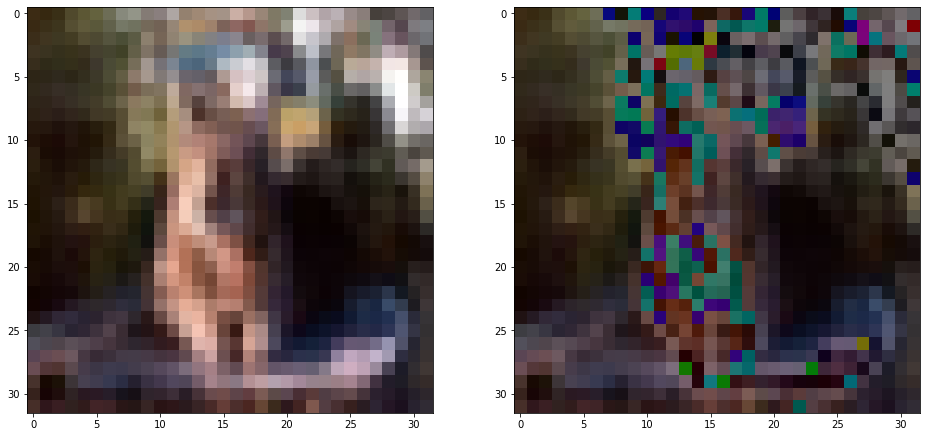

In [336]:
model.eval()
cam_extractor = SmoothGradCAMpp(model, input_shape=[3, 32, 32], target_layer=model.conv4)

images, labels = example.next()
output = model(images)

activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)

# Plot the image
"""
imshow(torchvision.utils.make_grid(images.detach()))
"""
# Plot the activation map on the input
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(images.reshape(3,32,32)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
"""
# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
"""
# Print real label
classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
print("Ground truth:\t",classes[labels.item()])
# Print predicted label
_, predictions = torch.max(output, 1)
print("Predicted:\t", classes[predictions.item()])
"""
# Plot the activation map on the output
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.axis('off')
plt.tight_layout()
plt.show()
"""
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im_transpose(torchvision.utils.make_grid(images.detach())))
ax2.imshow(result)
#fig.axes("off")
fig.set_size_inches((16,16))

## Transfer learning

In [174]:
# Loading a model
model = torchvision.models.resnet34(pretrained=True)
num_features = model.fc.in_features     # Getting the number of features going into the fully connected layer

model.fc = nn.Linear(num_features, 10)  # Redefining the layer with the same input features, but new output features (the amount of classes that we need to classify)
model.to(device)


criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08) # Comment this if a model is loaded


In [111]:
summary(model, (3, 32, 32))

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predictions = torch.max(outputs, 1)  # torch.max returns (value, index)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predictions[i]
            if(pred == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    accuracy = 100 * n_correct / n_samples
    print(f"General network accuracy = {accuracy}")

    for i in range(10):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]} class accuracy: \t \t {accuracy}%')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

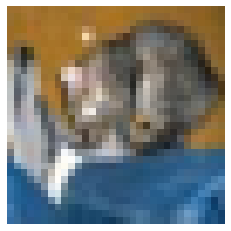

In [223]:
im(torchvision.utils.make_grid(images.detach()))